<a href="https://colab.research.google.com/github/anish-neervannan/ese546_final_project/blob/main/ese546_finalproj_stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test commit

### ESE 546 Final Project
### F2020
### Anish Neervannan
### Vinay Senthil
### Bhaskar Abhiraman

### Import Kaggle Dataset

Use Chrome Extension "[Get cookies.txt](https://chrome.google.com/webstore/detail/get-cookiestxt/bgaddhkoddajcdgocldbbfleckgcbcid?utm_campaign=en&utm_source=en-ha-na-us-bk-ext&utm_medium=ha)" to download cookies from [here](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) after logging in.

Save the file as "cookies.txt" and upload it in the next cell.

A version of "cookies.txt" is also in the shared Drive for this project.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving cookies.txt to cookies.txt


This cell then imports all the data (492 MB) straight from Kaggle to the Colab workspace.

In [ ]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/download" -O data.zip
!unzip data.zip

Eg. graph AAPL over time

         Date     Open     High      Low    Close    Volume  OpenInt
0  1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
1  1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
2  1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
3  1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
4  1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0


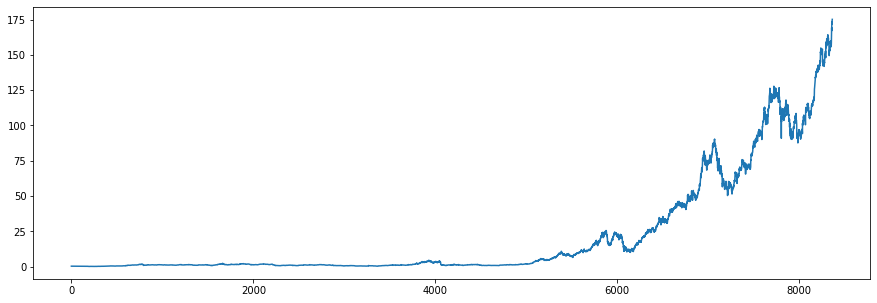

In [ ]:
aapl_data = pd.read_csv("Stocks/aapl.us.txt")
print(aapl_data.head())
plt.plot(aapl_data.Open)

### LSTM for Numerical Sequences

### To do:

*   Plagiarize less ***
*   Move training to GPU, implement cuda compatability
*   Validation metrics (MAE per sector)
*   Preprocess all stock data by sector/S&P
*   Implement mini-batching (looking at fixed-length sequences of various stocks)
*   Characterize base LSTM
*   Attention
*   Get S&P 500 info/sector info/stock symbols




In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  6 15:27:14 2020

LSTM for Numerical Sequences based on:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

@author: bhask
"""

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stock = 'aapl'
stock_pd_frame = pd.read_csv("Stocks/{}.us.txt".format(stock))
stock_opens = np.asarray(stock_pd_frame.Open)

test_data_size = 12
train_data_size = 500

train_data = stock_opens[-train_data_size-test_data_size:-test_data_size]
test_data = stock_opens[-test_data_size:]

#Put training data between -1 and 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)


class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        input_seq = torch.Tensor(input_seq)
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
model = LSTM()
loss_function = nn.MSELoss()
print(loss_function)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        labels = torch.Tensor(labels)
        #print('labels: ')
        #print(labels)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        #print('y_pred:')
        #print(y_pred)
        single_loss = loss_function(y_pred, torch.flatten(labels))
        single_loss.backward()
        optimizer.step()

    #TODO: Save average losses more frequently and plot them
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


MSELoss()
LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
epoch:   1 loss: 0.00026341
epoch:  26 loss: 0.00000656
epoch:  51 loss: 0.00318843
epoch:  76 loss: 0.00703235
epoch: 101 loss: 0.00724525
epoch: 126 loss: 0.00179940
epoch: 149 loss: 0.0001728122


In [ ]:
fut_pred = 12

test_inputs = np.ndarray.flatten(train_data_normalized[-train_window:]).tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))


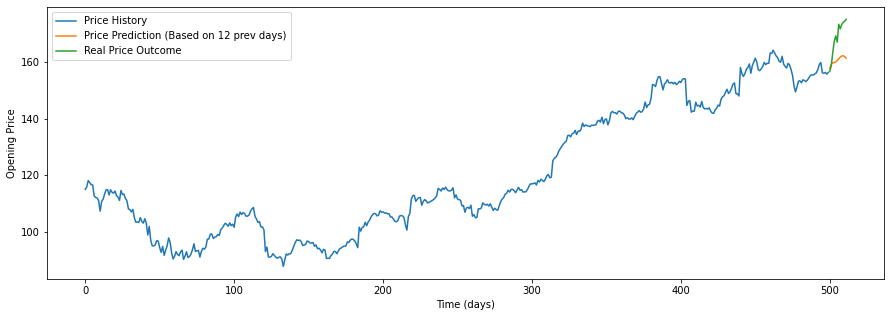

In [ ]:
ts = np.arange(0,train_data_size + test_data_size,1)
plt.plot(ts[:train_data_size],train_data)
plt.plot(ts[-test_data_size:],actual_predictions)
plt.plot(ts[-test_data_size:],stock_opens[-test_data_size:])
plt.xlabel('Time (days)')
plt.ylabel('Opening Price')
plt.legend(['Price History', 'Price Prediction (Based on 12 prev days)','Real Price Outcome'])